In [1]:
import numpy as np
import pandas as pd
import math
import sys
import progressbar
import matplotlib.pyplot as plt

In [2]:
def to_categorical(x, n_col=None):
    """ One-hot encoding номинального признака """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def divide_on_feature(X, feature_i, threshold):
    """ Разделение набора данных по превышению признака feature_i порога"""
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return [X_1, X_2]

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def shuffle_data(X, y, seed=None):
    """ случайное перемешивание X и y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Разделение набора данных на обучающий и тестовый """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def to_nominal(x):
    """ Перевод из one-hot encoding в номинальные значения """
    return np.argmax(x, axis=1)

def calculate_entropy(y):
    """ энтропия """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ дисперсия X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def mean_squared_error(y_true, y_pred):
    """ средняя квадратичная ошибка (y_true, y_pred) """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

def accuracy_score(y_true, y_pred):
    """ Доля правильных ответов """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
    
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)
    
    def hess(self, y, y_pred):
        return -np.ones(len(y))

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)
    
bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [3]:
class DecisionNode():
    """Узел или лист дерева

    Параметры:
    -----------
    feature_i: int
        Номер признака, используемого для ветвления.
    threshold: float
        Пороговое значение, с которым мы будем сравнивать значения признака feature_i при определении прогноза.
    value: float
        Предсказанный класс для задачи классификации или предсказанное значение числового признака y для задачи регрессии.
    true_branch: DecisionNode
        Следующий узел в случае превышения порога.
    false_branch: DecisionNode
        Следующий узел в случае недостижения порога.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          # Index for the feature that is tested
        self.threshold = threshold          # Threshold value for feature
        self.value = value                  # Value if the node is a leaf in the tree
        self.true_branch = true_branch      # 'Left' subtree
        self.false_branch = false_branch    # 'Right' subtree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Родительский класс для RegressionTree и ClassificationTree.

    Параметры:
    -----------
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потреь, используемая в градиентном бустинге для вычисления информативности.
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Построение дерева """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Рекурсивный метод, который строит дерево решений и разбивает X и соответствующий y 
        по признаку, который (на основе информативности) наилучшим образом разделяет данные"""

        largest_impurity = 0
        best_criteria = None    # номер факторного признака и порог
        best_sets = None        # Подмножества данных

        # 
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # 
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Вычисляем информативность для каждого факторного признака
            for feature_i in range(n_features):
                # ВСЕ значения признака feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Цикл по всем уникальным значениям feature_i с вычислением информативности
                for threshold in unique_values:
                    # Разделение X и y по критерию X[feature_i] >= threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Значения y-в двух подмножествах
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Вычисление информативности
                        impurity = self._impurity_calculation(y, y1, y2)

                        # Если порог привел к повышению информационного выигрыша,
                        # созраним порогт и номар признака
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X левого поддерева
                                "lefty": Xy1[:, n_features:],   # y левого поддерева
                                "rightX": Xy2[:, :n_features],  # X правого поддерева
                                "righty": Xy2[:, n_features:]   # y правого поддерева
                                }

        if largest_impurity > self.min_impurity:
            # Строим поддеревья
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # Определение значения в листе
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Рекурсивный поиск вниз по дереву с построением прогноза по значению итогового листа"""

        if tree is None:
            tree = self.root

        # Если мы находимся в листе, т.е. есть значение value, возвращаем его как прогноз
        if tree.value is not None:
            return tree.value

        # Выбор факторного признака
        feature_value = x[tree.feature_i]

        # Выбор левого или правого поддерева в зависимости от превышения порога
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Прогноз на поддереве
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Поэлементная классификация набора данных с возвращением множества прогнозов y"""
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Рекурсивный вывод дерева """
        if not tree:
            tree = self.root

        # Если это лист, выводим значение
        if tree.value is not None:
            print (tree.value)
        # иначе идем вглубь
        else:
            # номер признака и порог
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Сценарий при достижении порога
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Сценарий при недостижении порога
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)






class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Вычисление уменьшения дисперсии
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Вычисление информационного выигрыша
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Вычисление размера мажоритарного класса
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [4]:
class GradientBoosting(object):
    """Родительский класс для GradientBoostingClassifier и GradientBoostinRegressor. 
    Использует набор деревьев для обучения предсказанию градиента функции потерь. 

    Параметры:
    -----------
    n_estimators: int
        Число деревьев.
    learning_rate: float
        Скорость обучения - длина шага в направлении антиградиента
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потреь, используемая в градиентном бустинге для вычисления информативности.
    regression: boolean
        Регрессия или классификация.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)
        
        # Средняя квадратичная ошибка для регрессии, кросс-энтропия для классификации
        # Log loss for classification
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        # Инициализация
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in self.bar(range(self.n_estimators)):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Обновление прогноза y
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        # Вычисление прогнозов
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            # переход к распределению вероятностей
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Прогноз - значение с максимальной вероятностью
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

In [5]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

In [6]:
class LogisticLoss():
    def __init__(self):
        sigmoid = Sigmoid()
        self.log_func = sigmoid
        self.log_grad = sigmoid.gradient

    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p = self.log_func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)

    # gradient w.r.t y_pred
    def gradient(self, y, y_pred):
        p = self.log_func(y_pred)
        return -(y - p)

    # w.r.t y_pred
    def hess(self, y, y_pred):
        p = self.log_func(y_pred)
        return p * (1 - p)


In [7]:
class XGBoostRegressionTree(DecisionTree):
    """
    Дерево регрессии для XGBoost
    - Источник -
    http://xgboost.readthedocs.io/en/latest/model.html
    """

    def _split(self, y):
        """ Разделение y на истинные значения и прогнозы (в левой половине y истинные значения, в правой - прогнозы). """
        col = int(np.shape(y)[1]/2)
        y, y_pred = y[:, :col], y[:, col:]
        return y, y_pred

    def _gain(self, y, y_pred):
        nominator = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        denominator = self.loss.hess(y, y_pred).sum()
        return 0.5 * (nominator / denominator)

    def _gain_by_taylor(self, y, y1, y2):
        # Разделение
        y, y_pred = self._split(y)
        y1, y1_pred = self._split(y1)
        y2, y2_pred = self._split(y2)

        true_gain = self._gain(y1, y1_pred)
        false_gain = self._gain(y2, y2_pred)
        gain = self._gain(y, y_pred)
        return true_gain + false_gain - gain

    def _approximate_update(self, y):
        # разделение y на y, y_pred
        y, y_pred = self._split(y)
        # Метод Ньютона
        gradient = np.sum(y * self.loss.gradient(y, y_pred), axis=0)
        hessian = np.sum(self.loss.hess(y, y_pred), axis=0)
        update_approximation =  gradient / hessian

        return update_approximation

    def fit(self, X, y):
        self._impurity_calculation = self._gain_by_taylor
        self._leaf_value_calculation = self._approximate_update
        super(XGBoostRegressionTree, self).fit(X, y)

In [8]:
class XGBoost(object):
    """The XGBoost classifier.

    Reference: http://xgboost.readthedocs.io/en/latest/model.html

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further. 
    max_depth: int
        The maximum depth of a tree.
    """
    def __init__(self, n_estimators=200, learning_rate=0.001, min_samples_split=2,
                 min_impurity=1e-7, max_depth=2):
        self.n_estimators = n_estimators            # Number of trees
        self.learning_rate = learning_rate          # Step size for weight update
        self.min_samples_split = min_samples_split  # The minimum n of sampels to justify split
        self.min_impurity = min_impurity              # Minimum variance reduction to continue
        self.max_depth = max_depth                  # Maximum depth for tree

        self.bar = progressbar.ProgressBar(widgets=bar_widgets)
        
        # Log loss for classification
        self.loss = LogisticLoss()

        # Initialize regression trees
        self.trees = []
        for _ in range(n_estimators):
            tree = XGBoostRegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth,
                    loss=self.loss)

            self.trees.append(tree)

    def fit(self, X, y):
        y = to_categorical(y)

        y_pred = np.zeros(np.shape(y))
        for i in self.bar(range(self.n_estimators)):
            tree = self.trees[i]
            y_and_pred = np.concatenate((y, y_pred), axis=1)
            tree.fit(X, y_and_pred)
            update_pred = tree.predict(X)

            y_pred -= np.multiply(self.learning_rate, update_pred)

    def predict(self, X):
        y_pred = None
        # Make predictions
        for tree in self.trees:
            # Estimate gradient and update prediction
            update_pred = tree.predict(X)
            if y_pred is None:
                y_pred = np.zeros_like(update_pred)
            y_pred -= np.multiply(self.learning_rate, update_pred)

        # Turn into probability distribution (Softmax)
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        # Set label to the value that maximizes probability
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

Text(0, 0.5, 'X2')

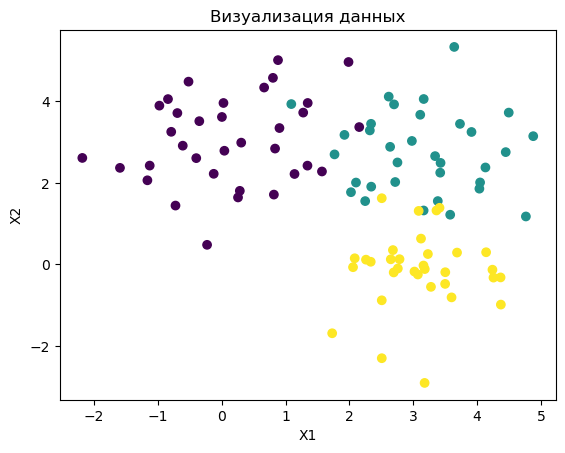

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=[(0,3),(3,3),(3,0)], 
                                      n_features=2, random_state=123,
                                      cluster_std=(0.9,0.9,0.9))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Визуализация данных')
plt.xlabel('X1')
plt.ylabel('X2')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, seed=123)

In [11]:
depth = 4
n_trees = 200

Training: 100% [------------------------------------------------] Time: 0:00:33


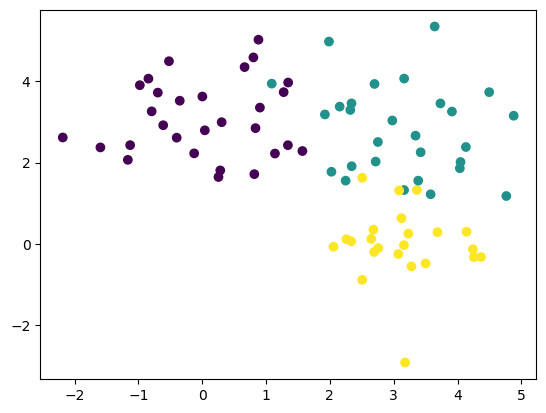

In [12]:
gb = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=.05, min_samples_split=4,
                 min_info_gain=1e-7, max_depth=depth, debug=False)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

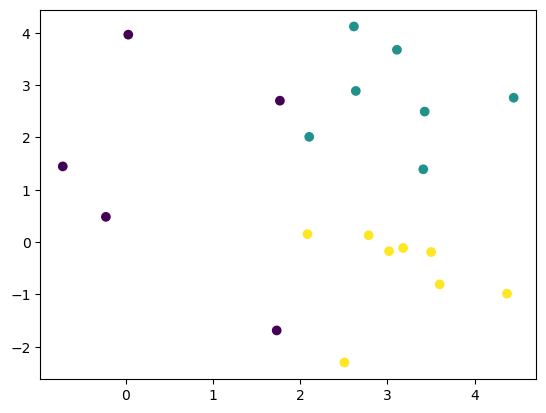

In [13]:
y_pred = gb.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

Training: 100% [------------------------------------------------] Time: 0:00:29


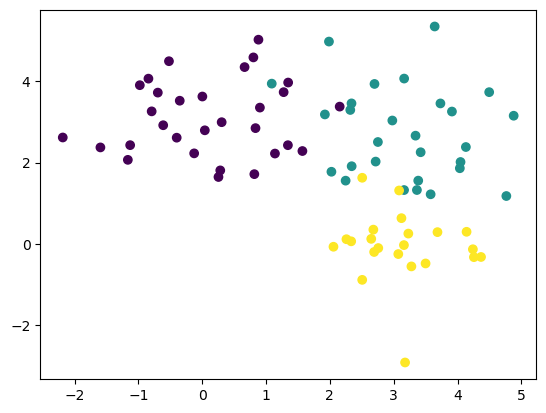

In [14]:
xgb = XGBoost(n_estimators=n_trees, learning_rate=.05, min_samples_split=4, min_impurity=1e-7, max_depth=depth)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

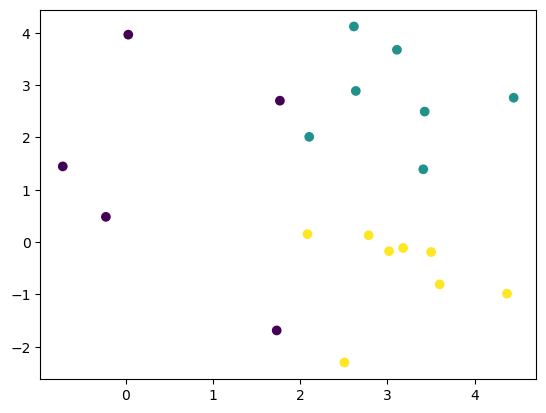

In [15]:
y_pred = xgb.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [16]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier



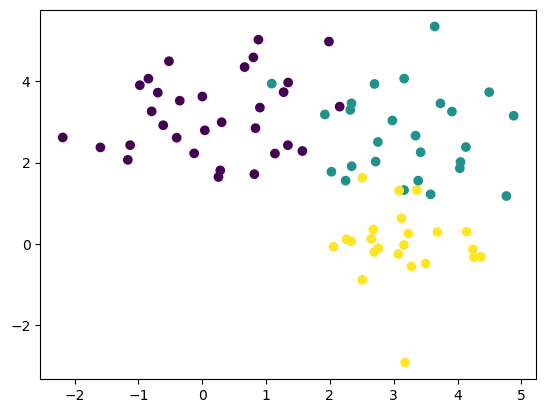

In [17]:

xgb_sk = XGBClassifier(n_estimators=n_trees, learning_rate=.05, max_depth=depth)
xgb_sk.fit(X_train, y_train)
y_pred = xgb_sk.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

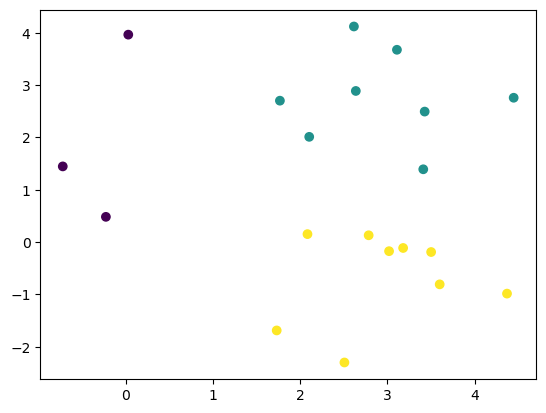

In [18]:
y_pred = xgb_sk.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [19]:
n_samples = 100
X = np.sort(np.random.rand(n_samples))
y = np.exp(X ** 2)+np.random.normal(0.0, 0.1, X.shape[0])
X = np.expand_dims(X, axis=1)
y = np.expand_dims(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, seed=123)

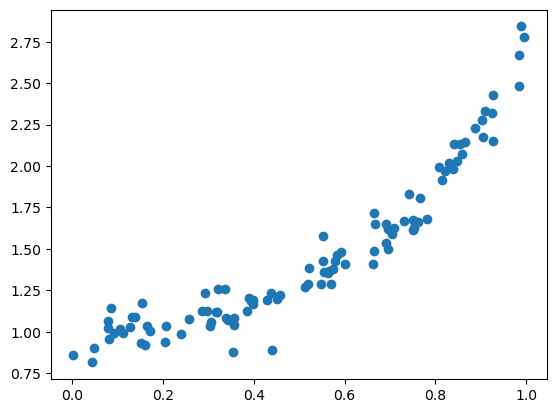

In [20]:
plt.scatter(X, y)

In [21]:

depth = 5
xbt = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=depth)
xbt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
y_pred = xbt.predict(X_train)


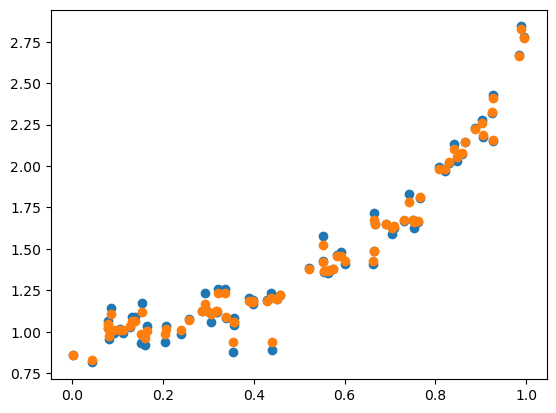

In [23]:

plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred)

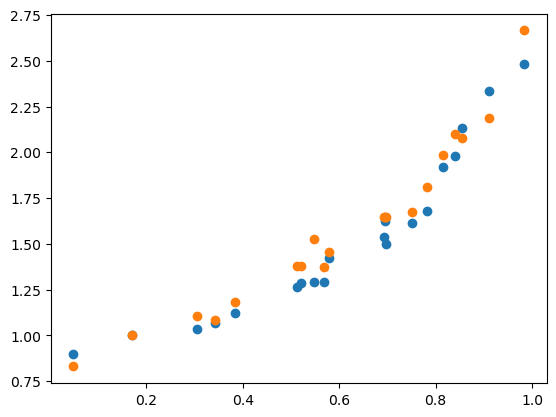

In [24]:
y_pred = xbt.predict(X_test)
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred)

С помощью XGBoost построить модели классификации для German Credit Cards и регрессии для Video Games, сравнить скорость и качество с предыдущими моделями

# Классификация

In [25]:
df = pd.read_csv('German Credit Cards UCI.csv')
df = df.drop('Customer ID', axis = 1)
df = df.drop_duplicates().reset_index(drop = True)
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12,current loans paid,furniture/equipment,1736,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,...,real estate,31,none,own,1,unskilled-resident,1,none,yes,fully paid
996,< 0 DM,30,current loans paid,car (used),3857,< 100 DM,1 - 4 years,4,male-divorced/separated,none,...,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes,fully paid
997,none,12,current loans paid,radio/television,804,< 100 DM,>= 7 years,4,male-single,none,...,car or other,38,none,own,1,skilled,1,none,yes,fully paid
998,< 0 DM,45,current loans paid,radio/television,1845,< 100 DM,1 - 4 years,4,male-single,none,...,unknown-none,23,none,for free,1,skilled,1,yes,yes,charged off


In [26]:
# сразу отделим целевую переменную
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Loan Status'] = labelencoder.fit_transform(df['Loan Status'].values)
y = np.array(df['Loan Status'])
df = df.drop('Loan Status', axis = 1)
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,Present Residence Time (Years),Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status
0,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,3,real estate,49,none,own,1,unskilled-resident,2,none,yes
3,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,4,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes
4,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,4,unknown-none,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12,current loans paid,furniture/equipment,1736,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,4,real estate,31,none,own,1,unskilled-resident,1,none,yes
996,< 0 DM,30,current loans paid,car (used),3857,< 100 DM,1 - 4 years,4,male-divorced/separated,none,4,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes
997,none,12,current loans paid,radio/television,804,< 100 DM,>= 7 years,4,male-single,none,4,car or other,38,none,own,1,skilled,1,none,yes
998,< 0 DM,45,current loans paid,radio/television,1845,< 100 DM,1 - 4 years,4,male-single,none,4,unknown-none,23,none,for free,1,skilled,1,yes,yes


In [27]:
# работа с числовыми признаками
df_num = df.select_dtypes(exclude = 'object')

def replace_outliers_with_median_for_column(df, column_name, threshold=1.5):
    data = df[column_name]
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    lower_bound = q25 - (threshold * iqr)
    upper_bound = q75 + (threshold * iqr)
    median = np.median(data)
    
    data_without_outliers = np.where((data < lower_bound) | (data > upper_bound), median, data)
    
    df[column_name] = data_without_outliers
    
    return df

replace_outliers_with_median_for_column(df, 'Loan Amount')
replace_outliers_with_median_for_column(df, 'Loan Duration (Months)')
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,Present Residence Time (Years),Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status
0,< 0 DM,6.0,critical account - other non-bank loans,radio/television,1169.0,unknown/none,>= 7 years,4,male-single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0 - 200 DM,18.0,current loans paid,radio/television,5951.0,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,none,12.0,critical account - other non-bank loans,education,2096.0,< 100 DM,4 - 7 years,2,male-single,none,3,real estate,49,none,own,1,unskilled-resident,2,none,yes
3,< 0 DM,42.0,current loans paid,furniture/equipment,7882.0,< 100 DM,4 - 7 years,2,male-single,guarantor,4,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes
4,< 0 DM,24.0,past payment delays,car (new),4870.0,< 100 DM,1 - 4 years,3,male-single,none,4,unknown-none,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12.0,current loans paid,furniture/equipment,1736.0,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,4,real estate,31,none,own,1,unskilled-resident,1,none,yes
996,< 0 DM,30.0,current loans paid,car (used),3857.0,< 100 DM,1 - 4 years,4,male-divorced/separated,none,4,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes
997,none,12.0,current loans paid,radio/television,804.0,< 100 DM,>= 7 years,4,male-single,none,4,car or other,38,none,own,1,skilled,1,none,yes
998,< 0 DM,18.0,current loans paid,radio/television,1845.0,< 100 DM,1 - 4 years,4,male-single,none,4,unknown-none,23,none,for free,1,skilled,1,yes,yes


In [28]:
df_obj = df.select_dtypes(include = 'object')

labelencoder = LabelEncoder()
df['Credit History'] = labelencoder.fit_transform(df['Credit History'].values)
df['Job Category'] = labelencoder.fit_transform(df['Job Category'].values)
df_obj = df_obj.drop(['Credit History','Job Category'], axis = 1)

df = pd.get_dummies(df, prefix= df_obj.columns, dtype="float64")
df

,Loan Duration (Months),Credit History,Loan Amount,Installment Rate in Percentage of Disposable Income,Present Residence Time (Years),Age (Years),Number of Existing Credits at This Bank,Job Category,Number of Dependents,Checking Account Status_0 - 200 DM,...,Other Credits_bank,Other Credits_none,Other Credits_stores,Home Ownership_for free,Home Ownership_own,Home Ownership_rent,Telephone_none,Telephone_yes,Foreign Worker Status_no,Foreign Worker Status_yes
0,6.0,1,1169.0,4,4,67,2,1,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,18.0,2,5951.0,2,2,22,1,1,1,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,12.0,1,2096.0,2,3,49,1,3,2,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,42.0,2,7882.0,2,4,45,1,1,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,24.0,4,4870.0,3,4,53,2,1,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,2,1736.0,3,4,31,1,3,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
996,30.0,2,3857.0,4,4,40,1,0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
997,12.0,2,804.0,4,4,38,1,1,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
998,18.0,2,1845.0,4,4,23,1,1,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [29]:
from sklearn.preprocessing import StandardScaler
def standardize_dataframe(df):
    scaler = StandardScaler()
    df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_standardized
df = standardize_dataframe(df)
df

,Loan Duration (Months),Credit History,Loan Amount,Installment Rate in Percentage of Disposable Income,Present Residence Time (Years),Age (Years),Number of Existing Credits at This Bank,Job Category,Number of Dependents,Checking Account Status_0 - 200 DM,...,Other Credits_bank,Other Credits_none,Other Credits_stores,Home Ownership_for free,Home Ownership_own,Home Ownership_rent,Telephone_none,Telephone_yes,Foreign Worker Status_no,Foreign Worker Status_yes
0,-1.437321,-0.894641,-0.858779,0.918477,1.046987,2.766456,1.027079,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,-1.214598,1.214598,-0.196014,0.196014
1,-0.071371,0.189772,1.913058,-0.870183,-0.765977,-1.191404,-0.704926,-0.289639,-0.428290,1.648476,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
2,-0.754346,-0.894641,-0.321453,-0.870183,0.140505,1.183312,-0.704926,1.824516,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
3,2.660529,0.189772,3.032342,-0.870183,1.046987,0.831502,-0.704926,-0.289639,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,0.823318,-0.823318,-0.196014,0.196014
4,0.611604,2.358599,1.286467,0.024147,1.046987,1.535122,1.027079,-0.289639,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,0.823318,-0.823318,-0.196014,0.196014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.754346,0.189772,-0.530123,0.024147,1.046987,-0.399832,-0.704926,1.824516,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
996,1.294579,0.189772,0.699292,0.918477,1.046987,0.391740,-0.704926,-1.346717,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,-1.214598,1.214598,-0.196014,0.196014
997,-0.754346,0.189772,-1.070348,0.918477,1.046987,0.215835,-0.704926,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
998,-0.071371,0.189772,-0.466943,0.918477,1.046987,-1.103451,-0.704926,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,-1.214598,1.214598,-0.196014,0.196014


In [30]:
X = np.array(df)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 54), (200, 54), (800,), (200,))

In [31]:
xgb = XGBoost(n_estimators=200, learning_rate=.05, min_samples_split=4, min_impurity=1e-7, max_depth=5)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
y_pred

Training: 100% [------------------------------------------------] Time: 0:22:42


array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,

In [32]:
accuracy_score(y_train, y_pred)

0.8

In [34]:
y_test_pr = xgb.predict(X_test)
y_test_pr

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1], dtype=int64)

In [35]:
accuracy_score(y_test, y_test_pr)

0.67

# Регрессия

In [36]:
df = pd.read_csv('Video Games.csv')
df

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...,...
4253,3996,PSP,2010,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4254,5720,Wii,2007,Shooter,Nintendo,3.06,1.18,0.46,1.29
4255,4579,3DS,2015,Action,FuRyu,0.00,0.00,0.00,1.06
4256,4072,GB,1996,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [37]:
df = df[df.na_sales <=10]
df = df[df.eu_sales < 7]
df = df[df.jp_sales < 10]
df = df.reset_index(drop = True)
df

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...,...
4240,3996,PSP,2010,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4241,5720,Wii,2007,Shooter,Nintendo,3.06,1.18,0.46,1.29
4242,4579,3DS,2015,Action,FuRyu,0.00,0.00,0.00,1.06
4243,4072,GB,1996,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [38]:
df = df.drop('id', axis = 1)

In [39]:
year = (df['year'] - df['year'].min ())/(df['year'].max() - df['year'].min())
df['year'] = year.values
df

,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,PSV,0.852941,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,SNES,0.382353,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,PSP,0.764706,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,DS,0.705882,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,PSV,0.970588,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...
4240,PSP,0.794118,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4241,Wii,0.705882,Shooter,Nintendo,3.06,1.18,0.46,1.29
4242,3DS,0.941176,Action,FuRyu,0.00,0.00,0.00,1.06
4243,GB,0.382353,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [40]:
df = pd.get_dummies(df, prefix=['platform', 'genre', 'publisher'], dtype="float64")
df

,year,na_sales,eu_sales,other_sales,jp_sales,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,...,publisher_Yacht Club Games,publisher_Yamasa Entertainment,publisher_Yeti,publisher_Yuke's,publisher_Yumedia,publisher_Zenrin,publisher_Zoo Digital Publishing,publisher_Zushi Games,publisher_dramatic create,publisher_imageepoch Inc.
0,0.852941,0.38,0.52,0.25,1.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.382353,0.00,0.00,0.00,1.31,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.764706,0.09,0.00,0.01,1.04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705882,0.00,0.00,0.00,1.08,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.970588,0.00,0.00,0.00,1.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,0.794118,0.00,0.00,0.00,1.09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.705882,3.06,1.18,0.46,1.29,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.941176,0.00,0.00,0.00,1.06,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4243,0.382353,0.00,0.00,0.00,1.27,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
Y = df['jp_sales']
X = df.drop(['jp_sales'], axis = 1)
X

,year,na_sales,eu_sales,other_sales,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,platform_GBA,...,publisher_Yacht Club Games,publisher_Yamasa Entertainment,publisher_Yeti,publisher_Yuke's,publisher_Yumedia,publisher_Zenrin,publisher_Zoo Digital Publishing,publisher_Zushi Games,publisher_dramatic create,publisher_imageepoch Inc.
0,0.852941,0.38,0.52,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.382353,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.764706,0.09,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705882,0.00,0.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.970588,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,0.794118,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.705882,3.06,1.18,0.46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.941176,0.00,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4243,0.382353,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3396, 315), (849, 315), (3396,), (849,))

In [43]:
X_train = np.array(X_train)
y_train = np.array(y_train.values)

In [44]:
xgb_r = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_train)
y_pred

array([1.0542291, 1.7131475, 1.2089138, ..., 2.13178  , 1.0842044,
       1.0975099], dtype=float32)

In [46]:
mean_squared_error(y_train, y_pred)

0.03165516633297793

In [48]:
y_test_pr = xgb_r.predict(X_test)
mean_squared_error(y_test, y_test_pr)

0.05249916400132536